# Classifer Model - ALT Playground USE THIS ONE FOR FINAL

## Evaluation Metric: __Accuracy__

The DrivenData Challenge Evaluation Metric is "Classification Rate" (AKA, Accuracy). 

"The metric used for this competition is the classification rate, which calculates the percentage of rows where the predicted class y^
in the submission matches the actual class, y in the test set. The maximum is 1 and the minimum is 0. The goal is to maximize the classification rate.

### Classes: Functional, Non Functional, and Functional Needs Repair

#### Class Frequency of the classes represented in the __Training__ dataset:
* Functional: 54.5%
* Non Functional: 38.7%
* Functional Needs Repair: 6.8%

There is a class imbalance issue, with __Functional Needs Repair__ as the rare class. 

In [1]:
# Load in libraries
import warnings
from importlib import reload
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

# ADD IN CORRECT CLASSIFIER MODEL LIBS!!!!!
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold # needed?

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score # needed?

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# needed?
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier




### Define local functions 

In [2]:
def plot_hist(the_df, the_col):
    plt.figure(figsize=(8,5))
    plt.grid(linestyle='dashed', alpha=0.3, zorder=0)
    plt.hist(the_df[the_col], alpha=0.8, zorder=2)
    plt.title(the_col.capitalize())
    plt.show()

def plot_confusion(ytrue, ypred):
    cm_norm = confusion_matrix(ytrue, ypred, normalize='true')
    sns.heatmap(cm_norm, cmap=sns.color_palette('Blues'), fmt='0.5g', annot=True, annot_kws={"va":"bottom"})
    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, cmap=sns.color_palette('Blues'), fmt='0.5g', annot=True, annot_kws={"va":"top"})
    plt.show()

def print_accuracy(model, X_train, y_train, X_test, y_test, cm=False, cr=False, get_y_hat=False):
    """ X's should be preprocessed identically.
        Confusion matrix: rows = TRUE, columns = predicted, 
        top L diagonal down to bottom R are TRUE-POSITIVE.
        TRUE-NEG: a 0 outside the TP diagonal.
        False-Pos: column of an item that is not in True row (falsely pred as item).
        False-Neg: row of an item that is not in Pred colum (falsey pred as NOT item)"""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    acc_test = round(accuracy_score(y_test, y_pred_test),3) * 100
    acc_train = round(accuracy_score(y_train, y_pred_train),3) * 100
    print(f'Test accuracy: {acc_test} %')
    print(f'Train accuracy: {acc_train} %')
    if cm == True:
        print(confusion_matrix(y_test, y_pred_test))
    if cr == True:
        print(classification_report(y_test, y_pred_test))
    if get_y_hat == True:
        return y_pred_test

def plot_confusion(model, X_test, y_test, normalize=None, form='.2f'):
    """ normalize{‘true’, ‘pred’, ‘all’}, default=None
        Normalizes over the true (rows), predicted (columns) conditions or all the population. 
        If None, confusion matrix will not be normalized."""
    plot_confusion_matrix(model, X_test, y_test, 
                          cmap=plt.cm.Blues, xticks_rotation='vertical',
                          normalize=normalize, values_format=form)
    plt.show()
    
def plot_feature_importance(model, ohencoder, X_encoder_input, num_features=25):
    top_features_list = []
    for item in zip(ohencoder.get_feature_names(X_encoder_input.columns), model.feature_importances_):
        if item[1] > 0:
            top_features_list.append(item)
    top_feats = sorted(top_features_list, key=lambda x: x[1], reverse=True)
    x_feats_importance = list(map(lambda x: x[1], top_feats[:num_features]))
    y_feats_labels = list(map(lambda x: x[0], top_feats[:num_features]))
    fig, ax = plt.subplots(figsize=(10,10))
    plt.barh(y_feats_labels, x_feats_importance, align='center', color='purple', alpha=0.8)
    ax.set_yticks(y_feats_labels)
    ax.set_yticklabels(y_feats_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Top {num_features} Features Ranked by Importance')
    plt.show()

### Load in Training Data

In [3]:
# read in the cleand training data
train_df = pd.read_csv('../data/train_processed_labeled.csv', index_col='id')

#### We created the following new columns for our EDA, but we do not want to use them in modeling for our Classifier.
* recorded_year -  Pulling out the year from date_recorded
* waterpoint_age - Calculate as recorded_year - construction_year
* recorded_good_quality - True if quality_group == 'good', False if  anything other than 'good'
* recorded_good_quantity - True if quanity_group == 'sufficient', False if anythign other than 'sufficient'

In [4]:
train_df.drop(['recorded_year', 'waterpoint_age', 'recorded_good_quality', 'recorded_good_quantity'], axis =1, inplace=True)

## Feature Selection and Engineering
Inspecting all the features and making initial choices on which ones to use for modeling.

In [5]:
# Take the TRAIN dataset provided by the Challenge and make a train/test split for local model creation. We only use the TEST for Challenge submisison.
X = train_df.drop(['status_group'], axis=1)
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


<AxesSubplot:>

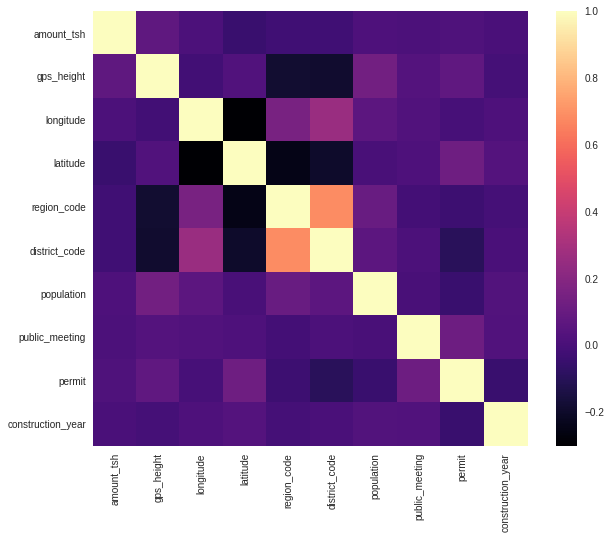

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), square=True, cmap='magma')

### Initial Feature Selection: NUMERIC
Opt to INCLUDE the following (starting out):
* __region_code__  This is the code for the Region. This feature can take the place of doing One Hot Encoding on the region feature which has the names of the regions.
* __construction_year__
* ? __gps_height__  
* ?__latitude__ 
* ?__longitude__ 


Opt to EXCLUDE the following (starting out):
* __district_code__ feature is highly (positively) correlated to region_code as Regions are divided into Districts. Looking at the value counts of district_code reveals that some districts are rarely represented. Favoring using region instead.
* ?__amount_tsh__ (not a lot of information provided by this feature)
* ? __population__ (not a lot of information provided by this feature)


#### Let's look at the categorical features next...

In [7]:
# Checking out the cardinality in categorical columns - # of different labels/ unique string values for a feature/column
for var in X_train.columns:
    # print the first 20 unique values in the Object columns
    if train_df[var].dtype == 'O':
        unique_vals = X_train[var].unique()
        print(var, ' cardinality:', unique_vals.size, ', first 20 unique:',  unique_vals[0:20], '\n')

date_recorded  cardinality: 348 , first 20 unique: ['2011-03-24' '2012-10-19' '2012-11-05' '2012-10-30' '2011-02-20'
 '2011-02-27' '2013-01-15' '2011-03-03' '2013-02-19' '2011-02-25'
 '2013-01-24' '2011-04-08' '2011-07-06' '2013-03-22' '2011-03-20'
 '2011-03-17' '2013-03-03' '2011-04-04' '2011-07-24' '2011-07-07'] 

funder  cardinality: 1656 , first 20 unique: ['kkkt' 'world vision' 'government of tanzania' 'unicef/ csp' 'world bank'
 'dhv' 'kalitasi' 'mkuyu' 'kkkt church' 'kibaha independent school'
 'danida' 'wananchi' 'lga' 'hans' 'md' 'roman' 'moravian' 'is' 'mission'
 'water user as'] 

installer  cardinality: 1701 , first 20 unique: ['kkkt' 'world vision' 'government' 'rdc' 'gwasco l'
 'china henan contractor' 'dwe' 'kalitasi' 'mkuyu' 'district council'
 'kkkt church' 'handeni trunk main(' 'dawasco' 'danida' 'wananchi' 'hans'
 'dw' 'commu' 'is' 'consulting engineer'] 

wpt_name  cardinality: 30166 , first 20 unique: ['kwa mzee amili' 'kwa mgaiwa' 'kwa mtoba hila' 'mzambalauni' 'a

### Initial Feature Selection: CATEGORICAL

Opt to INCLUDE the following (starting out):
* __basin__
* __quantity_group__ 
* __payment_type__
* __public_meeting__ - T/F values for some public meeting status
* __permit__ - T/F values for has permit
* __funder__ (w/ rare category encoding)
* __installer__ (w/ rare category encoding)
* __scheme_management__ (w/ rare category encoding)
* __extraction_type_class__ (w/ rare category encoding)
* __management_group__  (w/ rare category encoding)
* __quality_group__ (w/ rare category encoding)
* __source_type__ (w/ rare category encoding)
* __waterpoint_group_type__  (w/ rare category encoding)


Opt to EXCLUDE the following:
* __wpt_name__ - This identifier does not provide predictive information
* __scheme_name__ - This identifier for the name of the management scheme does not provide predictive info
* __recorded_by__ - All the same string/ does not provide predictive information
* __date_recorded__ - This variable doesn't provide predictive information since it is the just the day the survey occured
* __region__ - Information already captured by region_code, a numeric feature.
* Features that are sub-types of other features (ex:  waterpoint_type is a sub-type of waterpoint_type_group)
* Features with too high a cardinality/ where even the category with the highest percentage was less than 5% (ex: subvillage w/ 16642 unique categories)


#### Rare categories inspection

Apply rare category encoding for:
 * funder
 * installer
 * scheme_management
 * extraction_type_class (has 2 out of 7 w >5%)
 * management_group (has 3 of out 5 categories w/ > 5%)
 * quality_group (has 3 out of 6 categories w/ > 5%)
 * source_type (has 2 out of 7 categories w/ > 5%)
 * waterpoint_type_group (has 3 out of 6 categories w/ >5%)


I am not include features that have too high a cardinality/where even the category with the highest percentage was less than 5%.


NOTE: some the features are sub-types (ex: waterpoint_type is a sub-type of waterpoint_type_group), so I'm using the highest type in these cases:
* waterpoint_type_group
* source_type
* quality_group
* management_group
* extraction_type_class 
* quantity_group - does not need rare category encoding applied
* payment_type (seems to be a duplicate of the payment feature) - does not need rare category encoding applied


In [8]:
# Look for rarely occurring categories.

multi_cat_cols = []
multi_cat_series = []
for col in X_train.columns:

    if X_train[col].dtypes =='O': # if variable  is categorical
    
        if X_train[col].nunique() > 4: # choosing to inspect where there are more than 5 categories
            
            multi_cat_cols.append(col)  # add to the list
            count_series = X_train.groupby(col)[col].count()
            multi_cat_series.append(count_series)
            print(count_series/ len(X_train)) #  print the percentage of observations within each category
            print(count_series.values.max()/len(X_train), count_series.values.min()/len(X_train)) # print the max nad min percentages
            print()

date_recorded
2002-10-14    0.000022
2004-01-07    0.000022
2004-03-01    0.000065
2004-03-06    0.000022
2004-04-01    0.000022
                ...   
2013-11-02    0.000413
2013-11-03    0.003214
2013-12-01    0.000022
2013-12-02    0.000586
2013-12-03    0.004169
Name: date_recorded, Length: 348, dtype: float64
0.009793277164943976 2.1714583514288198e-05

funder
0                      0.013702
a/co germany           0.000261
aar                    0.000543
abas ka                0.000022
abasia                 0.000847
                         ...   
zaburi and neig        0.000022
zao                    0.000022
zao water spring       0.000065
zinduka                0.000022
zingibali secondary    0.000022
Name: funder, Length: 1656, dtype: float64
0.15263180752193173 2.1714583514288198e-05

installer
-                      0.000065
0                      0.013702
a.d.b                  0.000022
aar                    0.000087
aartisa                0.000022
                       

In [9]:
# Functions for rare category encoding
def find_non_rare_labels(df, col_name, tolerance):
    temp = df.groupby([col_name])[col_name].count() / len(df)
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    return non_rare


def rare_encoding(X_train, X_test, col_name, tolerance):
    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, col_name, tolerance)

    # re-group rare labels
    X_train[col_name] = np.where(X_train[col_name].isin(
        frequent_cat), X_train[col_name], 'rare')
    
    X_test[col_name] = np.where(X_test[col_name].isin(
        frequent_cat), X_test[col_name], 'rare')

    return X_train, X_test


def plot_rare_catgories(df, cols):
    for col in cols:

        temp_df = pd.Series(df[col].value_counts() / len(df) )

        # make plot with the above percentages
        fig = temp_df.sort_values(ascending=False).plot.bar(rot=50, alpha = 0.80,  colormap='magma')
        fig.set_xlabel(col)

        # add a line at 5 % to flag the threshold for rare categories
        fig.axhline(y=0.05, color='red')
        fig.set_ylabel('Percentage of categories')
        plt.show()

In [10]:
# Apply rare encoding to TRAIN and TEST
rare_cat_cols = ['funder', 'installer', 'scheme_management', 'extraction_type_class', 'management_group', 'quality_group', 'source_type', 
'waterpoint_type_group']

In [11]:
for col_name in rare_cat_cols:
    X_train, X_test = rare_encoding(X_train, X_test, col_name, 0.05)

In [12]:
## SELECTED FEATURES FOR MODELING
cont_features_to_use = ['region_code', 'construction_year']
cat_features_to_use = rare_cat_cols + ['basin', 'quantity_group', 'payment_type', 'permit', 'public_meeting']
features_to_use = cont_features_to_use + cat_features_to_use

### One Hot Encode the chosen categorical features

In [14]:
# Did our test train spilt before exploring features in X_Train for rare label encoding. 
# Now that I've selected some features based off of exploring X_Train ONLY, train the model on the chosen features
X_train = X_train[features_to_use]
X_test = X_test[features_to_use]

# OHE categorical features
ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')  
ohe.fit(X_train)

OneHotEncoder(handle_unknown='ignore')

In [15]:
print(features_to_use)

ohe.categories_

['region_code', 'construction_year', 'funder', 'installer', 'scheme_management', 'extraction_type_class', 'management_group', 'quality_group', 'source_type', 'waterpoint_type_group', 'basin', 'quantity_group', 'payment_type', 'permit', 'public_meeting']


[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
        1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
        1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
        1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
        2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]),
 array(['danida', 'government of tanzania', 'rare', 'unknown'],
       dtype=object),
 array(['dwe', 'rare', 'unknown'], dtype=object),
 array(['rare', 'unknown', 'vwc', 'water authority', 'wua', 'wug'],
       dtype=object),
 array(['gravity', 'handpump', 'motorpump', 'other', 'rare', 'submersible'],
       dtype=object),
 array(['commercial', 'rare', 'user-group'], dtype=object),
 array(['good', 'rare', 'salty'], dtype=object),
 array(['borehole', 'rare', 'river/lake', 'shallow well', 'spring'],
     

In [16]:
X_train_encoded = ohe.transform(X_train)
X_test_encoded = ohe.transform(X_test)


## Modeling!

Pipeline
Train
Predict
Check performance
Explore feature importance

### Local model train/tune/predict/check here
NOTE: Only using the TEST dataset for Challenge submission. 

### Random Forest

In [17]:
# Baseline RandomForest
base_rf_clf = RandomForestClassifier(verbose=2, n_jobs=-1)
base_rf_clf.fit(X_train_encoded, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
[Parallel(n_jobs

RandomForestClassifier(n_jobs=-1, verbose=2)

In [18]:
print_accuracy(base_rf_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
Test accuracy: 78.60000000000001 %
Train accuracy: 87.4 %
[[5521  146  606]
 [ 419  216  127]
 [1062  103 3313]]
                         precision    recall  f1-score   support

             functional       0.79      0.88      0.83      6273
functional needs repair       0.46      0.28      0.35       762
         non functional       0.82      0.74      0.78      4478

               accuracy                           0.79     11513
              macro avg       0.69      0.63      0.65     11513
           weighted avg       0.78      0.79      0.78     11513



In [66]:
# Try tuning with GridSearchCV
tuned_rf_clf = RandomForestClassifier(verbose=1)
forest_param_grid = {"n_estimators" : [50, 75, 100, 125],
            'criterion' : ['gini', 'entropy'],
            'max_depth' : [6, 10, 12],
            'min_samples_split' : [5, 10, 15],
            'min_samples_leaf' : [3, 7]
            }

gs_forest = GridSearchCV(estimator=tuned_rf_clf, param_grid=forest_param_grid, 
                          scoring='accuracy', cv=3, n_jobs=-1)
gs_forest.fit(X_train_encoded, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(verbose=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 10, 12], 'min_samples_leaf': [3, 7],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 75, 100, 125]},
             scoring='accuracy')

In [77]:
# Inspect the tuned random forest
print(gs_forest.best_params_)
print(gs_forest.score(X_train_encoded, y_train))
tuned_forest = gs_forest.best_estimator_
print(tuned_forest)
print_accuracy(gs_forest, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)


{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
0.7559715104664293
RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=3,
                       min_samples_split=5, n_estimators=50, verbose=1)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
Test accuracy: 75.1 %
Train accuracy: 75.6 %
[[6032    4  237]
 [ 669    4   89]
 [1863    2 2613]]
                         precision    recall  f1-score   support

             functional       0.70      0.96      0.81      6273
functional needs repair       0.40    

### Random Forest conclusion: 
* Baseline Random Forest model suffered from overfitting. 
* Tuned Random Forest model did not overfit. Accuracy was respectable. 

### Gradient Boosting models

In [30]:
# Baseline GradientBoostingClassifer
base_gb_clf = GradientBoostingClassifier(verbose=1, random_state=42)
base_gb_clf.fit(X_train_encoded, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8486           17.68s
         2           0.8232           17.66s
         3           0.8028           16.37s
         4           0.7862           15.94s
         5           0.7727           15.68s
         6           0.7614           15.07s
         7           0.7520           14.63s
         8           0.7434           14.34s
         9           0.7362           14.54s
        10           0.7298           14.70s
        20           0.6889           12.83s
        30           0.6668           10.60s
        40           0.6530            8.83s
        50           0.6423            7.15s
        60           0.6346            5.59s
        70           0.6286            4.15s
        80           0.6226            2.74s
        90           0.6177            1.36s
       100           0.6133            0.00s


GradientBoostingClassifier(random_state=42, verbose=1)

In [31]:
print_accuracy(base_gb_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)

Test accuracy: 74.4 %
Train accuracy: 74.6 %
[[5893    7  373]
 [ 610   37  115]
 [1834   12 2632]]
                         precision    recall  f1-score   support

             functional       0.71      0.94      0.81      6273
functional needs repair       0.66      0.05      0.09       762
         non functional       0.84      0.59      0.69      4478

               accuracy                           0.74     11513
              macro avg       0.74      0.53      0.53     11513
           weighted avg       0.76      0.74      0.72     11513



In [90]:
# Try tuning with GridSearchCV
tuned_gb_clf = GradientBoostingClassifier(verbose=2)
gb_param_grid = {'n_estimators':[32, 64, 100],
                'learning_rate' : [0.5, 0.1, 0.05],
                   'max_depth':[7,9,11]
                   }

gs_gb = GridSearchCV(estimator=tuned_gb_clf, param_grid=gb_param_grid, 
                          scoring='accuracy', cv=3, 
                          verbose=2, n_jobs=-1)

gs_gb.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 21.0min finished
      Iter       Train Loss   Remaining Time 
         1           0.8155            2.59m
         2           0.7672            2.60m
         3           0.7285            2.64m
         4           0.6969            2.65m
         5           0.6704            2.61m
         6           0.6481            2.53m
         7           0.6286            2.48m
         8           0.6119            2.43m
         9           0.5976            2.38m
        10           0.5849            2.33m
        11           0.5733            2.29m
        12           0.5635            2.24m
        13           0.5547            2.20m
        14           0.5466            2.15m
        15           0.5388            2.11m
        1

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(verbose=2), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1, 0.05],
                         'max_depth': [7, 9, 11],
                         'n_estimators': [32, 64, 100]},
             scoring='accuracy', verbose=2)

In [92]:
# Inspect the tuned Gradient Boosting model
print(gs_gb.best_params_)
print(gs_gb.score(X_train_encoded, y_train))
tuned_gb = gs_gb.best_estimator_
print(tuned_gb)
print_accuracy(gs_gb, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)

{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 100}
0.8514722487622688
GradientBoostingClassifier(max_depth=11, verbose=2)
Test accuracy: 78.8 %
Train accuracy: 85.1 %
[[5670  119  484]
 [ 452  201  109]
 [1193   83 3202]]
                         precision    recall  f1-score   support

             functional       0.78      0.90      0.83      6273
functional needs repair       0.50      0.26      0.35       762
         non functional       0.84      0.72      0.77      4478

               accuracy                           0.79     11513
              macro avg       0.71      0.63      0.65     11513
           weighted avg       0.78      0.79      0.78     11513



### Gradient Boosting conclusion:?
* Baseline model showed no signs of overfitting (test and train accuracy were consistent). Accuracy of 74% was acceptable.
* Tuned model had better accuracy at 79%  but showed some overfitting. Is it acceptable? 
* Choosing the Tuned model over the Baseline so that additional hyperparmeters could be set as part of Future Work

### XG Boost Classifer


In [94]:
# XGBoost
base_xgbt_clf = XGBClassifier()
base_xgbt_clf.fit(X_train_encoded, y_train)


XGBClassifier(objective='multi:softprob')

In [95]:
print_accuracy(base_xgbt_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)

Test accuracy: 73.4 %
Train accuracy: 73.6 %
[[5921    3  349]
 [ 656    1  105]
 [1951    0 2527]]
                         precision    recall  f1-score   support

             functional       0.69      0.94      0.80      6273
functional needs repair       0.25      0.00      0.00       762
         non functional       0.85      0.56      0.68      4478

               accuracy                           0.73     11513
              macro avg       0.60      0.50      0.49     11513
           weighted avg       0.72      0.73      0.70     11513



In [96]:
# try tuning the XGB
tuned_xgb_clf = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
}

gs_xgb = GridSearchCV(tuned_xgb_clf, param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
gs_xgb.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8], 'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [97]:
# Inspect the tuned XGBoost model
print(gs_xgb.best_params_)
print(gs_xgb.score(X_train_encoded, y_train))
tuned_xgb = gs_xgb.best_estimator_
print_accuracy(gs_xgb, X_train_encoded, y_train, X_test_encoded, y_test, cm=True, cr=True)

{'max_depth': 8, 'n_estimators': 200}
0.8120385651003214
XGBClassifier(max_depth=8, n_estimators=200, objective='multi:softprob')
Test accuracy: 78.5 %
Train accuracy: 81.2 %
[[5748   62  463]
 [ 508  137  117]
 [1286   45 3147]]
                         precision    recall  f1-score   support

             functional       0.76      0.92      0.83      6273
functional needs repair       0.56      0.18      0.27       762
         non functional       0.84      0.70      0.77      4478

               accuracy                           0.78     11513
              macro avg       0.72      0.60      0.62     11513
           weighted avg       0.78      0.78      0.77     11513



### XGBoost conclusion:
* The Baseline model had similar accuracy for train and test so no overfiiting. Accuracy was respectable at 73%
* The Tuned model did showed very slight overfitting with a higher train accuracy  but acceptable. Accuracy was better at 78.5%

## Model Face Off!
Tuned Gradient Boosted and Tuned XGBoost both had Accuracy ~78%. Which is actually "better"? 

Inspect the Confusion Matrix of both to see how well they performed for each class.



In [114]:
print('Tuned Gradient Boosted scores:')
print_accuracy(tuned_gb, X_train_encoded, y_train, X_test_encoded, y_test)
print('Tuned XGBoost scores:')
print_accuracy(tuned_xgb, X_train_encoded, y_train, X_test_encoded, y_test)

Tuned Gradient Boosted scores:
Test accuracy: 78.8 %
Train accuracy: 85.1 %
Tuned XGBoost scores:
Test accuracy: 78.5 %
Train accuracy: 81.2 %


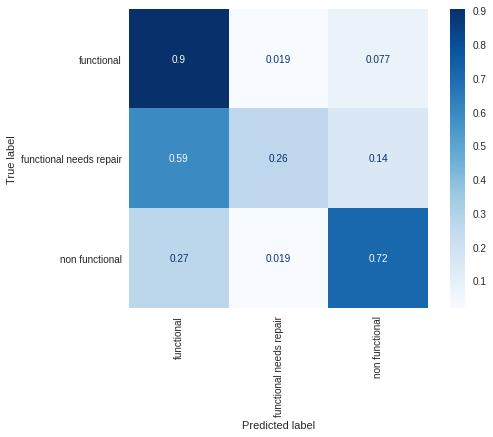

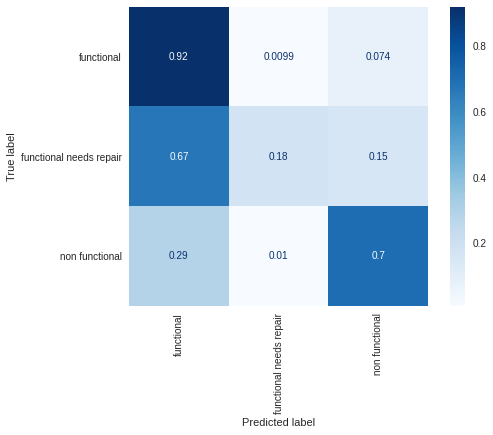

In [105]:
# compare tuned Gradient Boosted to Tuned XGBoost
plot_confusion_matrix(tuned_gb, X_test_encoded, y_test, normalize='true', cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.grid(b=None)
plt.show()

plot_confusion_matrix(tuned_xgb, X_test_encoded, y_test, normalize='true', cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.grid(b=None)
plt.show()

## Final Model Selection: Tuned Gradient Boosted Model
* Pros:
    * Best accuracy score of all attempted models
    * Best performance on classifying the rare class, functional needs repair (but still crummy at .26%)
* Cons:
    * Slight overfitting. Test accuracy: 78.8% Train accuracy: 85.1 %

In [115]:
final_model = tuned_gb

#### Important features
 Intuition tells us that the feature quantity_group_dry would be a good indicator of operational status.

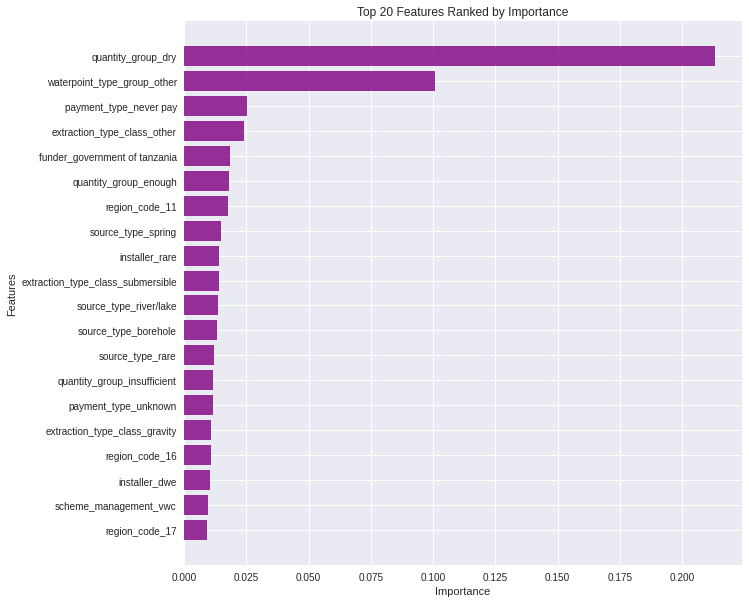

In [116]:
plot_feature_importance(final_model, ohe, X_train, num_features=20)

## Predict on Pump it Up Challenge Test/Validation dataset
The challenge submission process involved making predictions on their supplied Test/Validation dataset.  I used my final model (trained on 80% of the Challenge Training data) to make predictions for the Challenge.  

![water](../images/ChallengeScore.png)

Maybe later on I'll retain this tuned model on all of the Test data and resubmit. 

In [133]:
# read in the cleaned test data
validation_df = pd.read_csv('../data/test_processed.csv', index_col='id')
validation_df.shape

(14850, 38)

In [134]:
X_validate = validation_df

# Did our test train spilt before exploring features in X_Train for rare label encoding. 
# Now that I've selected some features based off of exploring X_Train ONLY, train the model on the chosen features
X_validate_selected_features = X_validate[features_to_use]

X_validate_encoded = ohe.transform(X_validate_selected_features)

In [136]:

y_validation = final_model.predict(X_validate_encoded)
predictions_df = pd.DataFrame(y_validation, index=X_validate_selected_features.index, columns=['status_group'])

#check format and prediction rate
print(predictions_df.head())
print(predictions_df.shape)
predictions_df['status_group'].value_counts(normalize=True)


         status_group
id                   
50785  non functional
51630      functional
17168  non functional
45559  non functional
49871      functional
(14850, 1)


functional                 0.647744
non functional             0.326734
functional needs repair    0.025522
Name: status_group, dtype: float64

In [137]:
# write the predictions out to file to submit to the Pump it Up challenge
predictions_df.to_csv('../data/challenge_submission.csv')